In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model
import json
import matplotlib.pylab as plt
import nltk
from nltk.corpus import stopwords

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Connor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Connor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
path = "goodreads_reviews_spoiler.json.gz"

In [4]:
data = []

In [5]:
for l in gzip.open(path, 'r'):
    d = json.loads(l)
    data.append(d)

In [6]:
data[0]

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'timestamp': '2017-08-30',
 'review_sentences': [[0, 'This is a special book.'],
  [0,
   'It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind.'],
  [0,
   'This is what I love about good science fiction - it pushes your thinking about where things can go.'],
  [0,
   "It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I've read."],
  [0,
   'For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc.'],
  [0, 'It is a book about science, and aliens.'],
  [0,
   'The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell.'],
  [1,
   'Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think a

In [7]:
# some useful data structures...
users_per_book = defaultdict(list)
books_per_user = defaultdict(list)

In [8]:
for d in data:
    u = d['user_id']
    b = d['book_id']
    users_per_book[b].append(u)
    books_per_user[u].append(b)

# Exploratory Analysis

In [9]:
print('total reviews, num users, num books')
len(data), len(books_per_user), len(users_per_book)

total reviews, num users, num books


(1378033, 18892, 25475)

In [10]:
timestamps = [d['timestamp'] for d in data]

In [11]:
timestamps = sorted(timestamps)
timestamps[0], timestamps[-1]

('2006-12-07', '2017-11-05')

In [12]:
has_spoiler = [d for d in data if d['has_spoiler']]

In [13]:
len(has_spoiler), len(has_spoiler) / len(data) * 100

(89627, 6.503980673902585)

In [14]:
ratings = [d['rating'] for d in data]

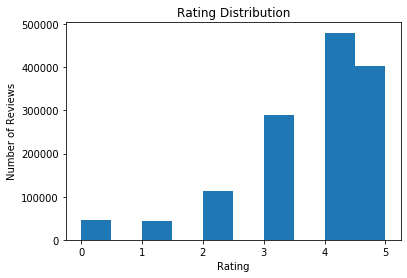

In [15]:
plt.hist(ratings)
plt.ylabel('Number of Reviews')
plt.xlabel('Rating')
plt.title('Rating Distribution')
plt.show()

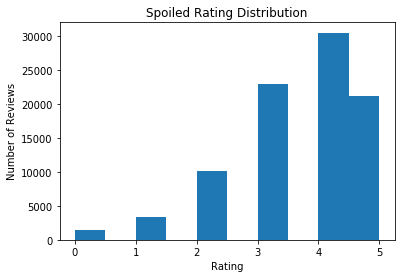

In [16]:
spoiled_ratings = [d['rating'] for d in has_spoiler]
plt.hist(spoiled_ratings)
plt.ylabel('Number of Reviews')
plt.xlabel('Rating')
plt.title('Spoiled Rating Distribution')
plt.show()

In [17]:
ave_rating = sum(spoiled_ratings) / len(spoiled_ratings)
ave_spoiled_rating = sum(ratings) / len(ratings)
ave_rating, ave_spoiled_rating

(3.577259084873978, 3.6850786592193367)

In [18]:
spoiled_review_length = []
spoiled_review_num_spoilers = []
i = 0
for d in has_spoiler:
    spoiled_review_num_spoilers.append(0)
    review_len = 0
    for b,s in d['review_sentences']:
        if b == 1:
            spoiled_review_num_spoilers[i] += 1
        review_len += 1 # len(s)
    spoiled_review_length.append(review_len)
    i += 1

In [19]:
#plt.hist(spoiled_review_length)

In [20]:
#plt.hist(spoiled_review_num_spoilers)

In [21]:
spoil_percentage = []
for i in range(0,len(spoiled_review_length)):
    p_spoiled = spoiled_review_num_spoilers[i] / spoiled_review_length[i] * 100
    spoil_percentage.append(p_spoiled)

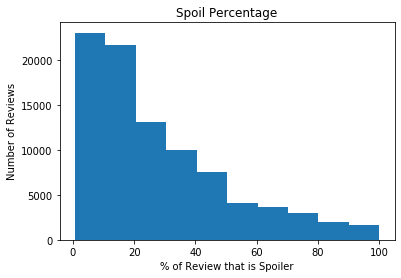

In [22]:
plt.hist(spoil_percentage)
plt.ylabel('Number of Reviews')
plt.xlabel('% of Review that is Spoiler')
plt.title('Spoil Percentage')
plt.show()

In [23]:
sum(spoil_percentage) / len(spoil_percentage)

28.241436491662572

In [24]:
spoiled_users_per_book = defaultdict(list)
spoiled_books_per_user = defaultdict(list) 
for d in has_spoiler:
    num_spoilers = 0
    review_len = 0
    for b,s in d['review_sentences']:
        if b == 1:
            num_spoilers += 1
        review_len += 1
    spoil_percentage = num_spoilers / review_len
    
    u = d['user_id']
    b = d['book_id']
    spoiled_books_per_user[u].append((b, spoil_percentage))
    spoiled_users_per_book[b].append((u, spoil_percentage))


In [25]:
len(spoiled_books_per_user), len(spoiled_users_per_book)

(16040, 24558)

In [26]:
users_average_spoilage = defaultdict(float)

for u in spoiled_books_per_user:
    spoilage_list = [x[1] for x in spoiled_books_per_user[u]]
    users_average_spoilage[u] = sum(spoilage_list) / len(spoilage_list)

In [27]:
books_average_spoilage = defaultdict(float)

for b in spoiled_users_per_book:
    user_list = [x[0] for x in spoiled_users_per_book[b]]
    spoilage_list = [users_average_spoilage[u] for u in user_list]
    books_average_spoilage[b] = sum(spoilage_list) / len(spoilage_list)

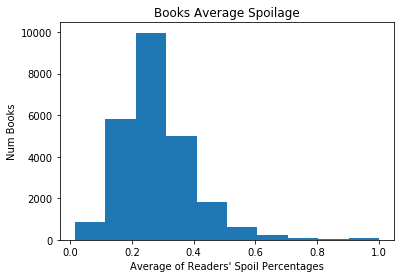

In [28]:
plt.hist(books_average_spoilage.values())
plt.title('Books Average Spoilage')
plt.ylabel('Num Books')
plt.xlabel('Average of Readers\' Spoil Percentages')
plt.show()

In [29]:
sum(books_average_spoilage.values()) / len(books_average_spoilage.values())

0.28350131162712416

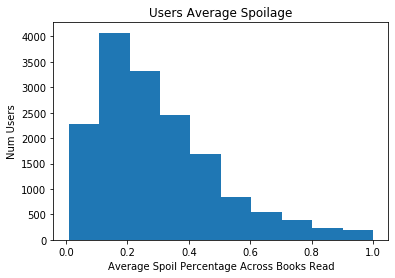

In [30]:
plt.hist(users_average_spoilage.values())
plt.title('Users Average Spoilage')
plt.ylabel('Num Users')
plt.xlabel('Average Spoil Percentage Across Books Read')
plt.show()

In [31]:
sum(users_average_spoilage.values()) / len(users_average_spoilage.values())

0.29916017025514124

# Predictive Task / Model

In [32]:
sentences = []
for d in has_spoiler:
    for b,s in d['review_sentences']:
        sentences.append((b,s,d['user_id'],d['book_id']))
len(sentences)

2131228

In [33]:
sentences[0]

(0, 'This is a special book.', '8842281e1d1347389f2ab93d60773d4d', '18245960')

In [34]:
unspoiled = [(s,u,b) for (f,s,u,b) in sentences if f == 0]
spoiled = [(s,u,b) for (f,s,u,b) in sentences if f == 1]
len(spoiled), len(unspoiled), len(spoiled) / len(sentences)

(569724, 1561504, 0.2673219383378972)

In [35]:
data = []
for i in range(0,200000):
    data.append((0,unspoiled[i]))
    data.append((1,spoiled[i]))
len(data)

400000

In [36]:
data[0], data[1]

((0,
  ('This is a special book.', '8842281e1d1347389f2ab93d60773d4d', '18245960')),
 (1,
  ('Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think about though.',
   '8842281e1d1347389f2ab93d60773d4d',
   '18245960')))

In [37]:
unigramCount = defaultdict(int)
#bigramCount = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = nltk.stem.porter.PorterStemmer()
for (f,(s,u,b)) in data:
    r = ''.join([c for c in s.lower() if not c in punctuation])
    unigrams = r.split()
#    bigrams = list(nltk.bigrams(unigrams))
    for w in unigrams:
#        if w in stopwords.words('english'):
#            continue
        w = stemmer.stem(w)
        unigramCount[w] += 1
#    for w in bigrams:
#        bigramCount[w] += 1

unigramCounts = [(unigramCount[w], w) for w in unigramCount]
unigramCounts.sort()
unigramCounts.reverse()

#bigramCounts = [(bigramCount[w], w) for w in bigramCount]
#bigramCounts.sort()
#bigramCounts.reverse()

In [38]:
unigramCounts[:10]#, bigramCounts[:10]

[(302346, 'the'),
 (192500, 'and'),
 (170685, 'i'),
 (163768, 'to'),
 (142160, 'a'),
 (129964, 'of'),
 (112745, 'it'),
 (108272, 'that'),
 (91705, 'wa'),
 (84304, 'in')]

In [39]:
NW = 2000 # dictionary size
unigramWords = [x[1] for x in unigramCounts[:NW]]
#bigramWords = [x[1] for x in bigramCounts[:NW]]

In [40]:
unigramId = dict(zip(unigramWords, range(len(unigramWords))))
unigramSet = set(unigramWords)
#bigramId = dict(zip(bigramWords, range(len(bigramWords))))
#bigramSet = set(bigramWords)

def feature(text,uid,bid):
    feat = [0]*(len(unigramWords))#+len(bigramWords))
    r = ''.join([c for c in text.lower() if not c in punctuation])
    unigrams = r.split()
#    bigrams = list(nltk.bigrams(unigrams))
    for w in unigrams:
#        if w in stopwords.words('english'):
#            continue
        w = stemmer.stem(w)
        if w in unigramSet:
            feat[unigramId[w]] += 1
#    for w in bigrams:
#        if w in bigramSet:
#            feat[bigramId[w]] += 1
    feat.append(users_average_spoilage[uid])
    feat.append(books_average_spoilage[bid])
    feat.append(1) #offset
    return feat

X = [feature(s,u,b) for (f,(s,u,b)) in data]
y = [f for (f,(s,u,b)) in data]

In [41]:
Xtrain = X[:9*len(X)//10]
ytrain = y[:9*len(y)//10]
Xvalid = X[9*len(X)//10:]
yvalid = y[9*len(y)//10:]

In [42]:
mod = linear_model.LogisticRegression(C=1)

In [43]:
mod.fit(Xtrain, ytrain)

C:\Users\Connor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
pred = mod.predict(Xvalid)

In [45]:
correct = pred == yvalid

In [46]:
accuracy = sum(correct) / len(correct)

In [47]:
true_pos = 0
true_neg = 0
for i in range(0,len(pred)):
    if pred[i] == yvalid[i]:
        if pred[i] == 1:
            true_pos += 1
        else:
            true_neg += 1
BER = 1 - (.5 * ((true_pos / (len(pred)/2)) + (true_neg / (len(pred)/2))))

In [48]:
accuracy, BER

(0.776375, 0.22362499999999996)

In [49]:
true_pos, true_neg

(15780, 15275)